#Классификация записей при помощи CNN: предобработка данных

## Необходимые библиотеки



In [6]:
import os, torch, librosa, sklearn, librosa.display
import numpy as np, pandas as pd, matplotlib.pyplot as plt

from IPython.display import Audio
from tqdm.auto import tqdm

random_state = 42

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path = "/content/drive/MyDrive/HSE/GTZAN/Data/"

## Загрузка данных

Загрузим данные в pandas dataframe. Как удалось выяснить из комментариев на kaggle, одна из аудиозаписей пустая, поэтому ее мы уберем из данных.

In [7]:
df = pd.read_csv(os.path.join(data_path, 'features_30_sec.csv'))

# удаление непроигрывающейся записи
df.drop(df.loc[df.filename == 'jazz.00054.wav'].index, inplace=True)

files, labels = df.filename, df.label

## Разделение на train и test

Разделим выборку на train, test, validate в отношении 0.8, 0.1, 0.1.

In [8]:
files_rest, files_test, labels_rest, labels_test = sklearn.model_selection.train_test_split(files, labels, stratify=labels, test_size=0.1, random_state=random_state)
files_train, files_val, labels_train, labels_val = sklearn.model_selection.train_test_split(files_rest, labels_rest, stratify=labels_rest, test_size=0.1/(1 - 0.1), random_state=random_state)
labels = {'train': labels_train, 'val': labels_val, 'test': labels_test}

Посмотрим непосредственно на пример аудиозаписи.

In [9]:
example_file, example_label = files_train.iloc[2], labels_train.iloc[2]
example_path = os.path.join(data_path, 'genres_original', example_label, example_file)
example_audio, sample_rate = librosa.load(example_path)
Audio(example_audio, rate=sample_rate)


## Извлечение признаков

### MFCC

Одними из самых информативных признаков для аудиофайлов являются [мел-кепстральные коэффициенты (MFCC)](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum). Это коэффициенты, характеризующие аудио и рассчитанные с учетом особенностей восприятия звука человеком. Считаются они для фреймов -- небольших отрывков аудиозаписи, для тридцатисекундных дорожек  фреймов должно быть примерно 1290.  Наиболее информативными считаются коэффициенты с 1 по 12, также нам будет удобно взять именно 12 коэффицентов, чтобы количество MFCC совпадало с количеством хромограмм, о которых будет написано ниже. 

Выберем некоторую дорожку из нашего датасета и построим спектр для этих коэффициентов.




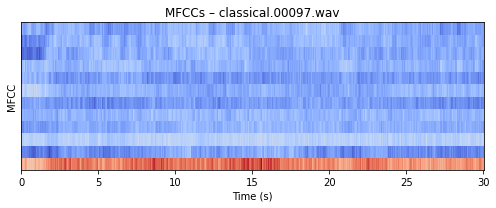

In [10]:
example_mfcc = librosa.feature.mfcc(example_audio, n_mfcc=13)[1:]
fig, ax = plt.subplots(figsize=(7, 3))
librosa.display.specshow(example_mfcc, ax=ax, x_axis='s')
ax.set(title=f'MFCCs – {example_file}', ylabel='MFCC')
plt.tight_layout()
plt.show()

### Хромограммы

Хромограмма показывает, как часто встречается определенный высотный класс в фрейме. Всего высотных классов 12 и хромограмма выглядит как вектор из 12 столбцов, заполненный числами от 0 до 1, характеризующими частоту соответствующего класса.

Построим пример для той же аудиозаписи.

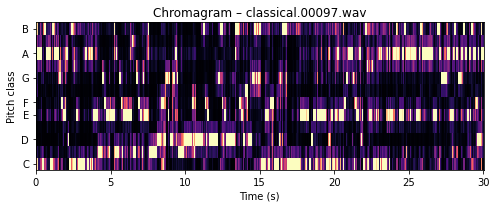

In [11]:
example_chroma = librosa.feature.chroma_stft(example_audio)
fig, ax = plt.subplots(figsize=(7, 3))
librosa.display.specshow(example_chroma, ax=ax, x_axis='s', y_axis='chroma')
ax.set(title=f'Chromagram – {example_file}')
plt.tight_layout()
plt.show()

### Delta и double-delta

Также в анализе звука используются признаки delta и double-delta, приближающие соответственно первую и вторую производную для других признаков, таких как MFCC или хромограммы. Они показывают динамику изменения признаков при переходе от фрейма к фрейму.

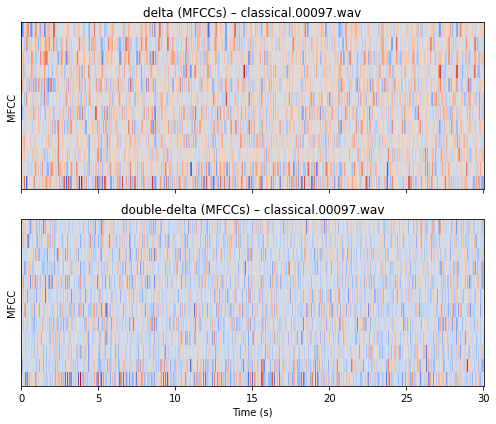

In [12]:
example_mfcc_delta = librosa.feature.delta(example_mfcc) 
example_mfcc_delta_delta = librosa.feature.delta(example_mfcc, order=2)

fig, axs = plt.subplots(2, 1, figsize=(7, 6), sharex=True)

librosa.display.specshow(example_mfcc_delta, ax=axs[0], x_axis='s')
axs[0].set(title=f'delta (MFCCs) – {example_file}', xlabel=None, ylabel='MFCC')

librosa.display.specshow(example_mfcc_delta_delta, ax=axs[1], x_axis='s')
axs[1].set(title=f'double-delta (MFCCs) – {example_file}', ylabel='MFCC')

plt.tight_layout()
plt.show()

## Вычисления

Создадим класс, в котором каждой аудиозаписи сопоставим тензор, состоящий из извлеченных из нее признаков. Для каждого фрейма будем считать все признаки, описанные выше.

Структура тензора будет следующей: каждый из типов признаков (то есть MFCC и хромограмма, и соответствующие delta и double-delta) будет отвечать отдельному каналу, таким образом, первая размерность тензора (количество каналов) равняется 6. Как уже говорилось ранее, количество коэффициентов MFCC и хромограмм одинаково и равняется 12, этому будет равняться вторая размерность тензора. И третья размерность равна количеству фреймов, то есть 1290.

In [17]:
n_features = 12   # количество признаков (MFCC и хромограммы у нас были согласованы по количеству)
n_frames = 1290  #количество фреймов, используемое для генерации MFCC и хромограмм 
# на самом деле оно автоматически вычисляется по аудиозаписи, но нам для решения задачи будет удобнее взять одно и то же число
n_channels = 6    # MFCC + delta + double-delta, хромограмма + delta + double-delta

class GTZAN(torch.utils.data.Dataset):
    def __init__(self, files, labels, n_features, scaler=None):
        super().__init__()
        self.files = files
        self.labels = labels
        self.n_features = n_features
        self.scaler = scaler
    
    def load_audio(self, index):
        # по индексу находим имя файла и его класс
        filename, label = self.files.iloc[index], self.labels.iloc[index]
        file_path = os.path.join(data_path, 'genres_original', label, filename)
        
        # загрузим аудио
        x, _ = librosa.load(file_path)
        
        return x
    
    def transform(self, x):
        # генерация MFCCs и соответствующих им delta и double-delta
        mfcc = librosa.feature.mfcc(x, n_mfcc=(self.n_features+1))[1:]
        mfcc_d, mfcc_dd = librosa.feature.delta(mfcc), librosa.feature.delta(mfcc, order=2)
        # n_features x n_frames

        # генерация хромограмм и соответствующих им delta и double-delta
        chroma = librosa.feature.chroma_stft(x)
        chroma_d, chroma_dd = librosa.feature.delta(chroma), librosa.feature.delta(chroma, order=2)
        # n_features x n_frames
        
        # Oставляем первые n_frames признаков
        return (mfcc[:, :n_frames], mfcc_d[:, :n_frames], mfcc_dd[:, :n_frames], chroma[:, :n_frames], chroma_d[:, :n_frames], chroma_dd[:, :n_frames])
    
    def to_tensor(self, x):
        # для удобства хранения и последующей работы передаем все в тензор
        return torch.Tensor(x)
        # n_cannels x n_features x n_frames
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        x = self.load_audio(index)
        x = self.transform(x)
        x = self.to_tensor(x)
        return x
    
    def plot(self, index, figsize=None):
        # построение спектра для всех характеристик аудиозаписи
        x = self.load_audio(index)
        x = self.transform(x)
        
        fig, axs = plt.subplots(3, 2, figsize=figsize)
        
        # MFCC
        axs[0][0].set_title('MFCC')
        librosa.display.specshow(x[0], ax=axs[0][0])
        axs[1][0].set_title('delta')
        librosa.display.specshow(x[1], ax=axs[1][0])
        axs[2][0].set_title('double-delta')
        librosa.display.specshow(x[2], ax=axs[2][0], x_axis='time')
        
        # хромограммы
        axs[0][1].set_title('Chroma')
        librosa.display.specshow(x[3], ax=axs[0][1], y_axis='chroma')
        axs[1][1].set_title('delta')
        librosa.display.specshow(x[4], ax=axs[1][1], y_axis='chroma')
        axs[2][1].set_title('double-delta')
        librosa.display.specshow(x[5], ax=axs[2][1], x_axis='time', y_axis='chroma')
        
        plt.tight_layout()
        
    

Положим наши данные в соответствующие датасеты

In [21]:
splits = {
    'train': GTZAN(files_train, labels_train, n_features=n_features, scaler=None),
    'val': GTZAN(files_val, labels_val, n_features=n_features, scaler=None),
    'test': GTZAN(files_test, labels_test, n_features=n_features, scaler=None)
}

Посмотрим на признаки для какой-нибудь аудиозаписи, так будет понятнее, как конкретно выглядят данные в тензоре признаков.

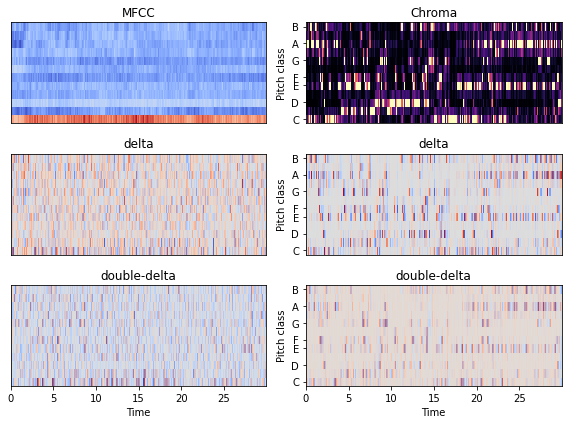

In [19]:
splits['train'].plot(2, figsize=(8, 6))

## Сохранение данных

Сохраним данные, извлеченные из аудиозаписей, для того, чтобы в последствии использовать их в классификации с помощью CNN.

In [23]:
for split in tqdm(('train', 'val', 'test'), desc='Split'):
    split_data_path = os.path.join(data_path, 'prepared_data', split, 'data')
    print(split)
    os.makedirs(split_data_path, exist_ok=True)
    
    split_data = splits[split]
    labels[split].reset_index(drop=True).to_csv(os.path.join(data_path, 'prepared_data', split, 'labels.csv'))
    split_data.files.reset_index(drop=True).to_csv(os.path.join(data_path, 'prepared_data', split, 'filenames.csv'))
    
    for i, data in tqdm(enumerate(split_data), total=len(split_data), desc='Sample', leave=False):
        torch.save(data, os.path.join(split_data_path, f'{i}.pt'))

Split:   0%|          | 0/3 [00:00<?, ?it/s]

train


Sample:   0%|          | 0/799 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


val


Sample:   0%|          | 0/100 [00:00<?, ?it/s]

test


Sample:   0%|          | 0/100 [00:00<?, ?it/s]

In [25]:
names = pd.read_csv(os.path.join(data_path, 'prepared_data', split, 'filenames.csv'))
names

,Unnamed: 0,filename
0,0,disco.00092.wav
1,1,hiphop.00016.wav
2,2,classical.00006.wav
3,3,blues.00021.wav
4,4,rock.00063.wav
...,...,...
95,95,metal.00098.wav
96,96,hiphop.00062.wav
97,97,disco.00029.wav
98,98,metal.00018.wav
